In [11]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.interpolate import griddata
import scipy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from skimage.morphology import square, dilation
from skimage import data, util
from skimage.measure import label, perimeter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn
import umap

import seaborn as sns
import os
import re
import json
import sys
import shutil
import pickle

import pipe_util2
import cc3d_util as cu

In [2]:
def geo_df_generate(feature_folder, res_folder, name="geo_props"):
    
    geo_csvs = pipe_util2.folder_file_num(feature_folder, ".csv")
    df_list = []
    # merge all dfs
    i = 0
    while i<len(geo_csvs):
        df = pd.read_csv(geo_csvs[i], index_col=0)
        df_list.append(df)
    #     if i%1000==0:
    #         print(i)
        i = i+1
    geo_df = pd.concat(df_list, ignore_index = True)


    # removing records that don't have matching part.
    for r in geo_df.rep_inx.unique():

        for i in geo_df.iter_inx.unique():
            temp = geo_df.loc[(geo_df.rep_inx==r) & (geo_df.iter_inx==i)].copy()
            if temp.shape[0]==1:
                print(temp.shape, r, i)
                geo_df.drop(temp.index, inplace = True)

    res_folder = pipe_util2.folder_verify(res_folder)
    pipe_util2.create_folder(res_folder)
    geo_df.to_csv(res_folder+name+".csv")

In [3]:
def mode_predicting(geo_df, final_timepoint, 
                    scaler_file, kmean1_file, 
                    umap2_file, kmean2_file):
    
    with open(kmean1_file, "rb") as f:
        model1 = pickle.load(f)
    
    with open(scaler_file, "rb") as f:
        scaler1 = pickle.load(f)

    with open(kmean2_file, "rb") as f:
        model2 = pickle.load(f) 

    with open(umap2_file, "rb") as f:
        umap2 = pickle.load(f)
    
    # geo df for timepoint 270 no selection for columns
    geo_270 = geo_df.loc[geo_df.timepoint==final_timepoint].reset_index(drop=True).copy()

    cols = ['s', 'd', 'd_std', 'area_frac', 'area_convex_frac',
        'peri', 'peri_convex', "minor_major_ratio", 'compact',
        'eccentric', 'circular', 'convexity', 'solidity',
        'radial_dist_cx_std', 'sphericity', 'radial_dist_cn_mean',
       'radial_dist_cn_std']

    # geo features for differences
    geo_df_270 = geo_df.loc[geo_df.timepoint==final_timepoint][cols].reset_index(drop=True).copy()
    geo_df_90 = geo_df.loc[geo_df.timepoint==90][cols].reset_index(drop=True).copy()
    #print("lalala",geo_df_270.shape)

    geo_diff_df = geo_df_270.divide(geo_df_90, axis='index').copy()
    geo_diff_df['dxy_std'] = geo_df[geo_df.timepoint==final_timepoint].dxy_std.values
    geo_diff_df['dxy_mean'] = geo_df[geo_df.timepoint==final_timepoint].dxy_mean.values
    
    # scale
    # Apply feature scaling to the general population demographics data.
    scaled_geo_diff = pd.DataFrame(scaler1.transform(geo_diff_df))
    scaled_geo_diff.columns = geo_diff_df.columns
    scaled_geo_diff.index = geo_diff_df.index

    # clustering 1
    # Re-fit the k-means model with the selected number of clusters and obtain
    # cluster predictions for the general population demographics data.
    scaled_geo_diff_select = scaled_geo_diff[["s", "d","d_std", 
                                          "radial_dist_cn_std",
                                          "radial_dist_cn_mean",
                                          "dxy_std"]].copy()
    kmean_geo_diff_select = model1.predict(scaled_geo_diff_select)
    geo_270["mode1"] = kmean_geo_diff_select
    geo_270["mode2"] = kmean_geo_diff_select
    # updating modes
    mig_mode_num = 0
    nmg_mode_num = 1
    geo_270.loc[geo_270["mode1"]==nmg_mode_num,"mode1"]=3
    
    # clustering 2
    scaled_mig_geo_diff_select = scaled_geo_diff[geo_270.mode2==mig_mode_num]
    if scaled_mig_geo_diff_select.shape[0]==0:
        print("All modes are non-migrative.")
        return 0
    embedding = umap2.transform(scaled_mig_geo_diff_select)
    embedding = pd.DataFrame(embedding)
    # Re-fit the k-means model with the selected number of clusters and obtain
    # cluster predictions for the general population demographics data.
    kmean_geo_diff_select = model2.predict(embedding)
    geo_270.loc[geo_270["mode2"]==mig_mode_num,"mode1"] = kmean_geo_diff_select
    # updating modes
    rad_mode_num = 0
    dir_mode_num = 1
    geo_270.loc[geo_270["mode1"]==rad_mode_num,"mode1"]=4
    geo_270.loc[geo_270["mode1"]==dir_mode_num,"mode1"]=5
    geo_270['mode1'] = geo_270['mode1']-2

    return geo_270

# fpp and force scan
# 1. Importing data

In [4]:
res_folder = "12222021_formal5_hope_force_fpp_scan_calc5_cluster/"
geo_270_file = res_folder+"geo_270.csv"
geo_props_file = res_folder+"geo_props.csv"
scaled_geo_diff_fpp_force_file = res_folder+"geo_props.csv"

geo_270 = pd.read_csv(geo_270_file, index_col=0)
geo_props = pd.read_csv(geo_props_file, index_col=0)
scaled_geo_diff_fpp_force = pd.read_csv(scaled_geo_diff_fpp_force_file, index_col=0)

In [5]:
geo_270_half = geo_270.loc[geo_270.fpp_scan<501, :].reset_index(drop=True).copy()
geo_270_half.shape

(6050, 56)

# 3. Drawing polarity

In [7]:
geo_270_half.head(2)

,rep_inx,iter_inx,timepoint,scan_f,scan_inx,jasn_file,scan_keys,scan_param,traj,mode_temp,...,p_mean_180,tumor_p_var_180,cell_p_var_180,p_mean_30,tumor_p_var_30,cell_p_var_30,fpp_scan,force_scan,mode1,mode2
0,0,0,270,/net/capricorn/home/xing/huijing/Migration/CC3...,0,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 0.0,/net/capricorn/home/xing/huijing/Migration/CC3...,1,...,0.008195,0.967403,0.961911,0.009550,0.972116,0.911498,0,0,1,1
1,0,105,270,/net/capricorn/home/xing/huijing/Migration/CC3...,105,/net/capricorn/home/xing/huijing/Migration/CC3...,fpp_scan force_scan,0.0 150.0,/net/capricorn/home/xing/huijing/Migration/CC3...,2,...,0.088982,0.988887,0.897002,0.023675,0.994505,0.678038,0,150,2,0


In [8]:
# y is force.
y = np.linspace(0,300,11)
x = np.linspace(0,500,11) # x is fpp

polarity_mean_num = []
polarity_std_num = []

xx = []
yy = []

i = 0
while i<len(geo_270_half.fpp_scan.unique()):
    
    j = 0
    while j<len(geo_270_half.force_scan.unique()):
        
        
        slice_df = geo_270_half.loc[((geo_270_half.force_scan==y[j])&(geo_270_half.fpp_scan==x[i]))]
        por = slice_df.p_mean_180.mean()
        pcs = slice_df.cell_p_var_180.mean()
        
        xx.append(x[i])
        yy.append(y[j])

        polarity_mean_num.append(por)
        polarity_std_num.append(pcs)
        
        j = j+1
    i = i+1

polarity_mean_num = np.array(polarity_mean_num)
polarity_std_num = np.array(polarity_std_num)

In [26]:
from scipy.interpolate import griddata
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

def other_land_draw_griddata(mg_list, x, y, 
                             cmap, zlabel, fig_folder, name, zlim, 
                             method = "cubic", view=215, linsp=8):
    
    def myfmt(x, pos):
        return '{0:.2f}'.format(x)
    
    fig_folder = pipe_util2.folder_verify(fig_folder)
    points = np.array([x,y]).T
    xnew, ynew = np.mgrid[min(x):max(x):80j, min(y):max(y):80j]
    grid_mg = griddata(points, mg_list, (xnew, ynew), method=method)
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca(projection='3d')
    im = ax.plot_surface(xnew, ynew, grid_mg, cmap=cmap, 
                    rstride=1, cstride=1, alpha=1, antialiased=True)

    cb = plt.colorbar(im, fraction = 0.03, pad =0.08, format=ticker.FuncFormatter(myfmt))
    cb.outline.set_visible(False)
    cb.ax.yaxis.set_label_coords(4.2,10.5)
    cb.ax.tick_params(labelsize=16)
    
    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph
    cset = ax.contour(xnew, ynew, grid_mg, zdir='z', 
                      alpha = 0.4,
                      offset=zlim[0], cmap=cmap)
    
    ax.set_xlabel(r"Protrusion force f", fontsize = 20)
    ax.set_ylabel(r"Adhesion $\lambda_{fpp}$", fontsize = 20)
    ax.set_zlabel("\n"+zlabel, fontsize = 20, rotation=90, 
                  linespacing=linsp)
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    
    ax.tick_params(axis='x', labelsize=16)  # only affects
    ax.tick_params(axis='y', labelsize=16)  # tick labels
    ax.tick_params(axis='z', labelsize=16)  # not tick marks
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    ax.set(zlim=zlim)
    ax.set_box_aspect(aspect = (1,1,1))
    ax.view_init(35, 120)
    
    
    plt.savefig(fig_folder+name+".pdf", dpi = 200, bbox_inches = "tight")
    plt.show()
    
    return xnew, ynew, grid_mg

/tmp/ipykernel_1003673/3258708037.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


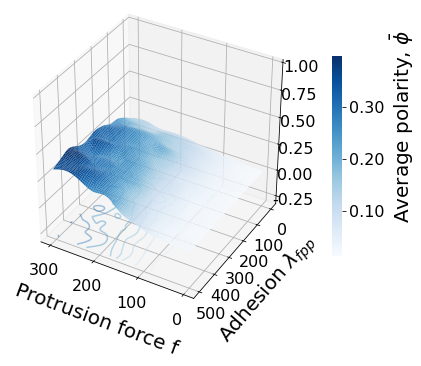

/tmp/ipykernel_1003673/3258708037.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


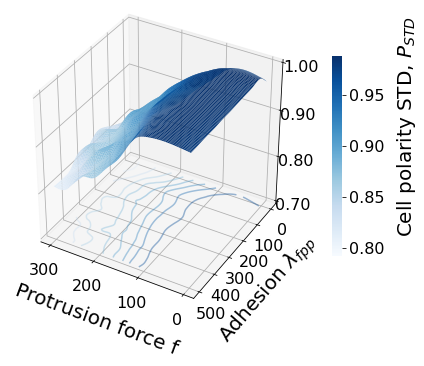

In [27]:
rcParams['axes.labelpad'] = 12
x_persis, y_persis, grid_persis = other_land_draw_griddata(polarity_mean_num, yy, xx, 
                                                           "Blues",r'Average polarity, $\bar{\phi}$', 
                                                           res_folder, "11062022_3_0_polarity_mean_landscape", 
                                                           zlim = [-0.3,1], linsp=7)


x_polar, y_polar, grid_polar = other_land_draw_griddata(polarity_std_num, yy, xx, 
                                                        "Blues",r'Cell polarity STD, $P_{STD}$', 
                                                        res_folder, "11062022_3_1_polarity_std_landscape",
                                                        zlim = [0.7,1], linsp=9
                                                       )